In [1]:
import re


def split_string_by_multi_markers(content: str, markers: list[str]) -> list[str]:
    """Split a string by multiple markers"""
    if not markers:
        return [content]
    results = re.split("|".join(re.escape(marker) for marker in markers), content)
    return [r.strip() for r in results if r.strip()]


In [2]:
jsonl_path='/home/pubw/proj/UserIntent/gen_rag/attri_list/output.jsonl'
import json
def open_jsonl(jsonl_path):
    items={}
    with open(jsonl_path, 'r', encoding='utf-8') as infile:
        for line in infile:
            json_item=json.loads(line)
            #print(json_item['caption4label'])
            sp_str=split_string_by_multi_markers(json_item['caption4label'][0],['##','<|完成|>'])
            if len (sp_str)>15:
                continue
            attribuate_list=[]
            for sub_str in sp_str:
                sub_str=re.search(r"\((.*)\)", sub_str)
                if sub_str is None:
                    continue
                sub_str=sub_str.group(1)
                #print(sub_str)
                attribuate_list.append(split_string_by_multi_markers(sub_str,['<|>']))
            if json_item['output'] not in items:
                items[json_item['output']]=[]
            items[json_item['output']].append(attribuate_list)
    return items
caption_list=open_jsonl(jsonl_path)

In [3]:
local_summary="""
目标:输入标签和样本信息，总结最可能出现哪些元素，并分析原因
输入: 标签名称,区域,元素
输入元素格式：(元素名<|>元素种类<|>布局<|>具体信息<|>标签分析)
对于具体每个元素：
- 元素名 具体的手机图标按钮名称或者实物名称
- 布局 元素之间的关系或者是页面内的位置信息
- 具体信息 元素具体有哪些信息，表达了什么信息
- 标签分析 为什么这个元素属于图片的分类标签
输出格式：<|>指定标签<|>图片区域<|>可能出现哪些具体元素<|>分析原因<|>
要求:哪些具体元素名 需要进行筛选，选出可能性最高的部分
#########################
例子1 Output:
<|>退货页面<|>页面底部<|>退货页面, 退货商品信息, 退货按钮, 退款成功, 退货运费未付提示, 退货方式选择<|>这些元素通常出现在退货页面的核心部分，涉及退货流程的不同阶段，如商家同意退货、退货商品信息展示、选择退货方式、支付运费等。退货按钮是用户操作的核心入口，退款成功元素展示了最终状态，退货方式选择帮助用户选择合适的退货服务。这些元素属于典型的退货页面元素，因为它们提供了用户退货流程的指导、选择和确认功能。<|>
例子2 Output:
<|>支付页面<|>页面中部<|>支付费用详情, 支付按钮, 运费详情, 选择支付方式, 客服, 包裹状态更新, 修改信息, 88VIP退货包运费, 运费险, 订单详情<|>这些元素是支付页面的核心组成部分，它们提供了用户完成支付所需的所有关键信息和操作选项。
例子3 Output:
<|>商品分类选项<|>页面顶部<|>商品分类选项, 商品图片, 已选商品数量和状态<|>页面顶部区域作为用户首次接触网页内容的地方，通常用于放置导航栏和其他重要元素，以引导用户的浏览行为。<|>
#########################
Input: 这些图片的标签是[{label}],他们在区域[{local}]出现了以下元素:{attribute}
#########################
Output:
"""

In [4]:
def rebuild_info(caption_list):
    local_list=["中部","顶部","底部","页面某处"]
    def set_local(local_input,local_list):
        for local in local_list[:-1]:
            if local in local_input:
                return local
        return "页面某处"
    attribute_list={}
    for label in caption_list:
        i=0
        prompt_list={}
        for item in caption_list[label]:
            i+=1
            sample_classication={}
            for class_local in local_list:
                sample_classication[class_local]=[]
            for attribute_item in item:
                local=set_local(attribute_item[2],local_list)
                #print(attribute_item[2])
                sample_classication[local].append(attribute_item)

            for class_local in local_list:
                if class_local not in prompt_list:
                    prompt_list[class_local]=[]
                if len(sample_classication[class_local])>0:
                    prompt_list[class_local].append(sample_classication[class_local])          
        attribute_list[label]=prompt_list
    return attribute_list

In [5]:
caption_list=rebuild_info(caption_list)

In [6]:

def get_middle_num(samples_text,return_num=10):
    # 按照字符串长度排序
    sorted_samples = sorted(samples_text, key=len)
    
    # 计算中间位置
    n = len(sorted_samples)
    middle_pos = n // 2
    
    # 如果列表长度小于等于return_num，则返回整个列表
    if n <= return_num:
        return sorted_samples
    
    # 计算开始和结束的位置以获取中间的return_num个元素
    start_pos = max(0, middle_pos - return_num//2)  # 不低于列表起始位置
    end_pos = min(n, middle_pos + return_num//2)    # 不超过列表结束位置
    
    # 获取并返回中间的return_num个元素
    middle_sub = sorted_samples[start_pos:end_pos]
    
    # 如果获取到的元素少于return_num个，可以尝试调整范围
    # 这里简单处理，如果不足return_num个则返回尽可能多的中间元素
    if len(middle_sub) < return_num and start_pos > 0:
        # 尝试从左边补充元素
        while len(middle_sub) < return_num and start_pos > 0:
            start_pos -= 1
            middle_sub = sorted_samples[start_pos:end_pos]
    
    return middle_sub


In [7]:

all_input=[]
for label in caption_list:
    if label=="其他类别图片" : 
        continue
    for local in caption_list[label]:
        i=0
        samples_text=''
        samples_text_list=[]
        samples_list= caption_list[label][local]
        samples_list=get_middle_num(samples_list)
        #print(samples_list)
        for attribute_list in  samples_list:
            i+=1
            formal_list=[]
            for sample in  attribute_list:
                del sample[1]
                formal_list.append("<|>".join(sample))
            samples_text=f"样本{i}中"+"##".join(formal_list)
            samples_text_list.append(samples_text)
        input_text=local_summary.format(label=label,local=local,attribute="\n".join(samples_text_list))
        all_input.append((label,local,input_text))


In [8]:
all_input

[('购物车页面',
  '中部',
  '\n目标:输入标签和样本信息，总结最可能出现哪些元素，并分析原因\n输入: 标签名称,区域,元素\n输入元素格式：(元素名<|>元素种类<|>布局<|>具体信息<|>标签分析)\n对于具体每个元素：\n- 元素名 具体的手机图标按钮名称或者实物名称\n- 布局 元素之间的关系或者是页面内的位置信息\n- 具体信息 元素具体有哪些信息，表达了什么信息\n- 标签分析 为什么这个元素属于图片的分类标签\n输出格式：<|>指定标签<|>图片区域<|>可能出现哪些具体元素<|>分析原因<|>\n要求:哪些具体元素名 需要进行筛选，选出可能性最高的部分\n#########################\n例子1 Output:\n<|>退货页面<|>页面底部<|>退货页面, 退货商品信息, 退货按钮, 退款成功, 退货运费未付提示, 退货方式选择<|>这些元素通常出现在退货页面的核心部分，涉及退货流程的不同阶段，如商家同意退货、退货商品信息展示、选择退货方式、支付运费等。退货按钮是用户操作的核心入口，退款成功元素展示了最终状态，退货方式选择帮助用户选择合适的退货服务。这些元素属于典型的退货页面元素，因为它们提供了用户退货流程的指导、选择和确认功能。<|>\n例子2 Output:\n<|>支付页面<|>页面中部<|>支付费用详情, 支付按钮, 运费详情, 选择支付方式, 客服, 包裹状态更新, 修改信息, 88VIP退货包运费, 运费险, 订单详情<|>这些元素是支付页面的核心组成部分，它们提供了用户完成支付所需的所有关键信息和操作选项。\n例子3 Output:\n<|>商品分类选项<|>页面顶部<|>商品分类选项, 商品图片, 已选商品数量和状态<|>页面顶部区域作为用户首次接触网页内容的地方，通常用于放置导航栏和其他重要元素，以引导用户的浏览行为。<|>\n#########################\nInput: 这些图片的标签是[购物车页面],他们在区域[中部]出现了以下元素:样本1中金额明细<|>页面中部<|>显示实际优惠金额和减去的金额，提供购物车页面的优惠信息<|>购物车页面的优惠信息展示，属于购物车页面\n样本2中已选商品列表<|>页面中部<|>显示已选商品的详细信息，包括商品图片、名称、价格和数量<|

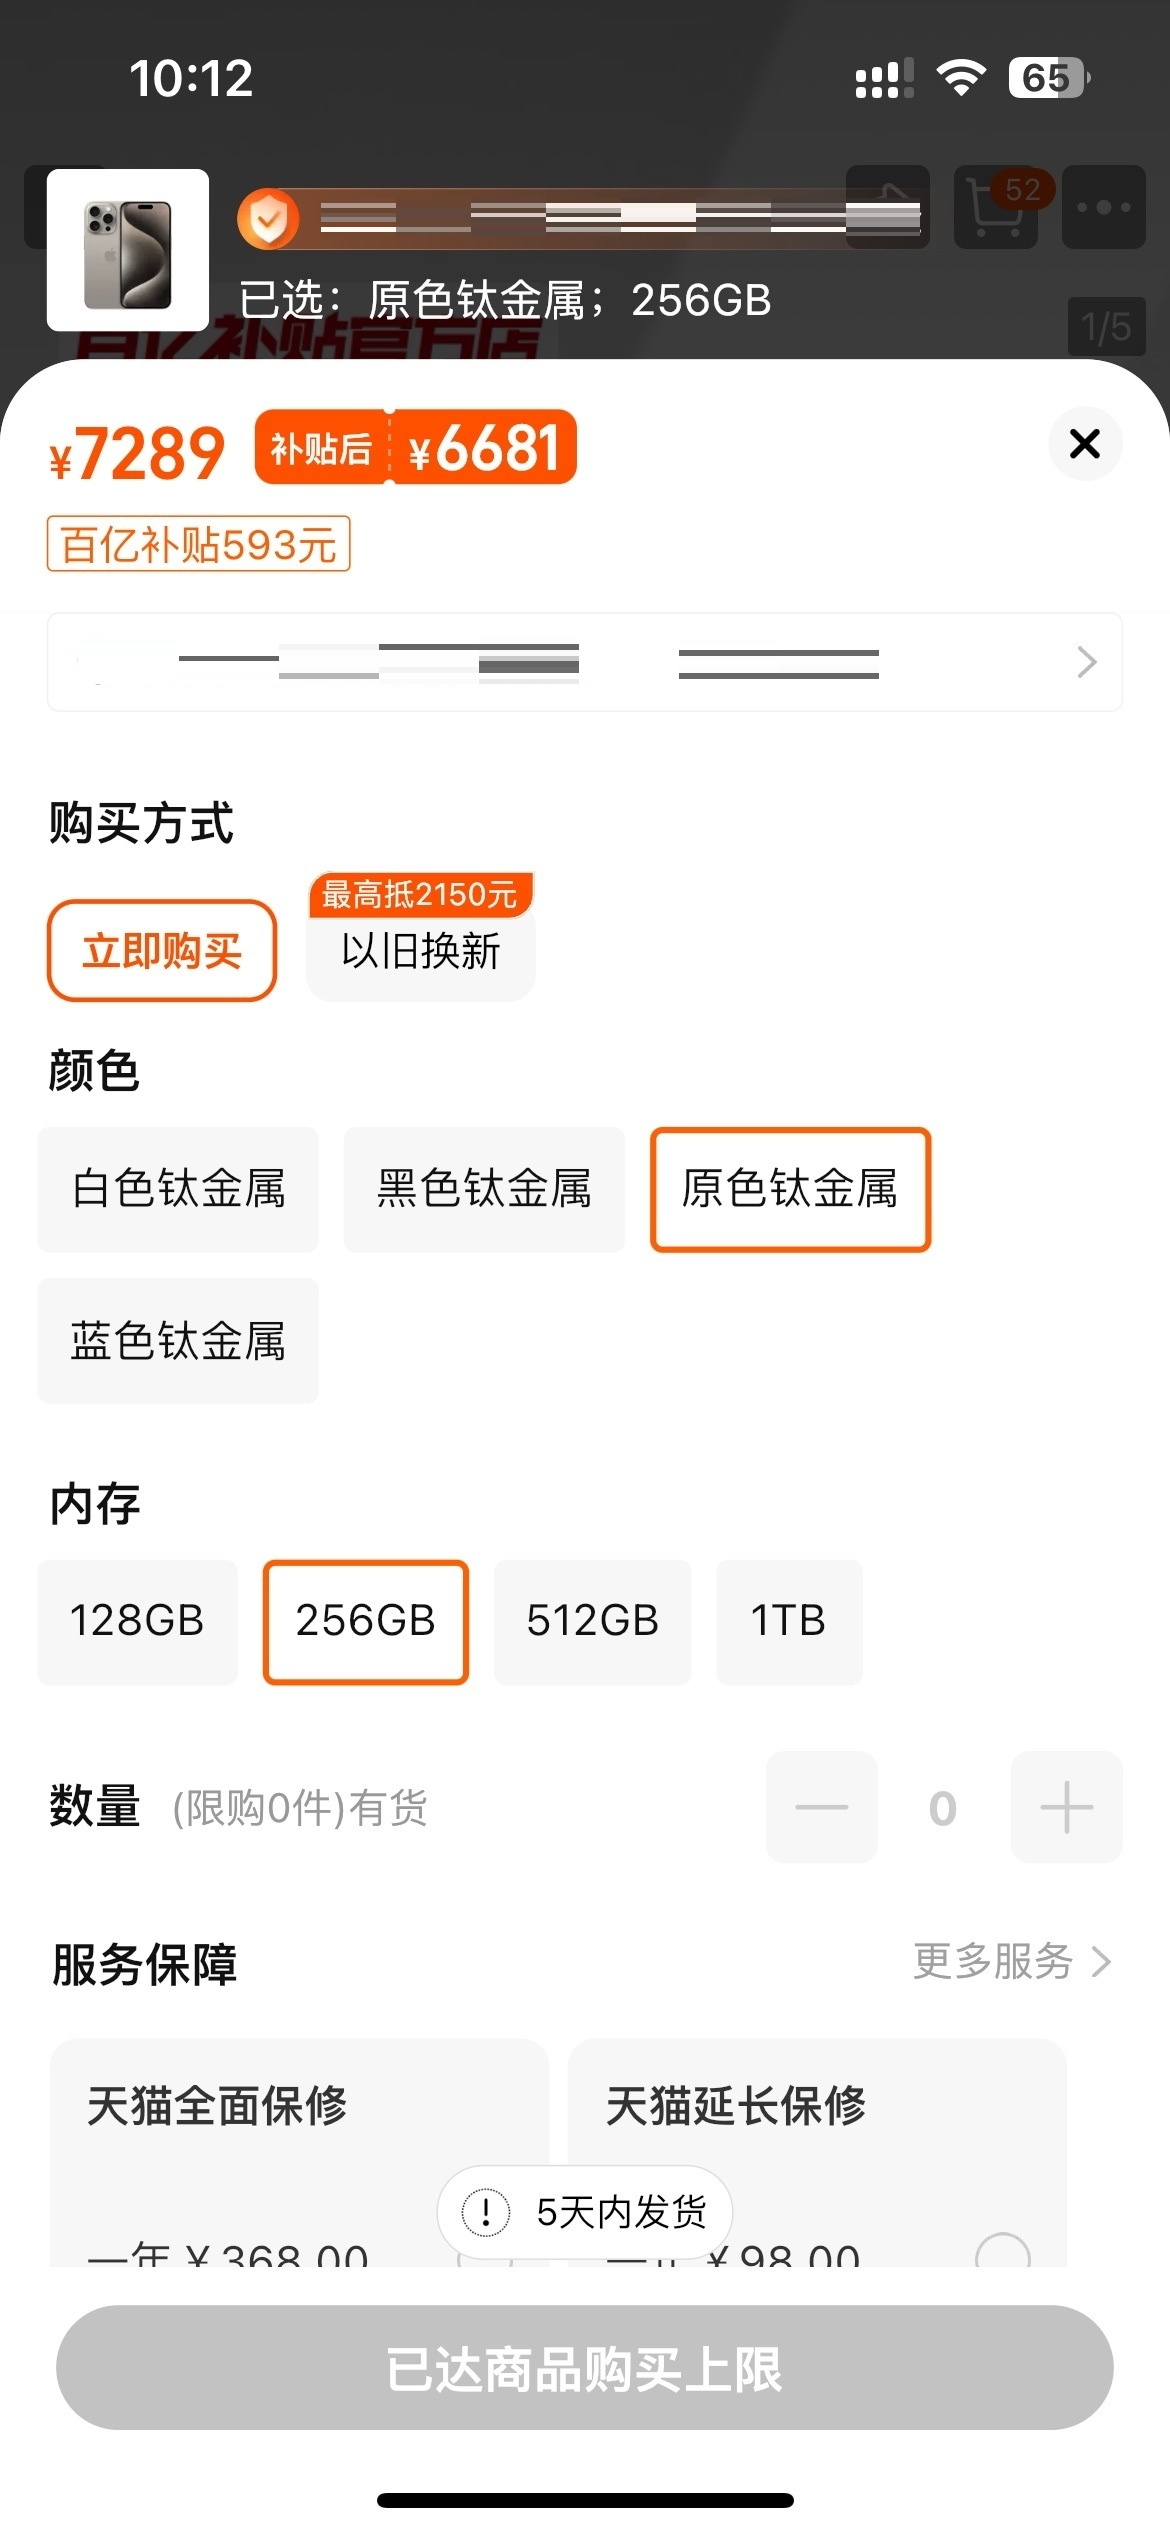

In [2]:
from IPython.display import Image, display

# 图片路径
image_path = "/home/pubw/datasets/www25/train/images/85bc84fc-84f5-45ea-a6f6-37e2e573647d-116-0.jpg"

# 显示图片
display(Image(filename=image_path, width=200, height=200))

In [10]:
import json
def open_summary(jsonl_path):
    items={}
    with open(jsonl_path, 'r', encoding='utf-8') as infile:
        for line in infile:
            json_item=json.loads(line)
            label_local=next(iter(json_item))
            label_local_list=label_local.split('-')
            label=label_local_list[0]
            local=label_local_list[1]
            sp_str=split_string_by_multi_markers(json_item[label_local],['<|>'])
            attributes=sp_str[0].split(';')
            local_list=[]
            if label not in items:
                items[label]={}
            for item in attributes:
                if label not in item and local not in item and item != "":
                    local_list.append(item)
            items[label][local]=local_list
    return items

In [11]:
items=open_summary('/home/pubw/proj/UserIntent/gen_rag/summary/output.jsonl')

In [12]:
label_template="""标签【{label}】:"""
local_template="""{local}：{attributs}"""
prompt_list=[]
for label in items:
    if label =='实物拍摄(含售后)':
        prompt="实物拍摄(含售后):为拍摄照片，非手机页面截图\n"
        prompt_list.append(prompt)
        continue
    prompt=label_template.format(label=label)
    for local in items[label]:
        local_prompt=local_template.format(local=local,attributs=",".join(items[label][local]))
        prompt=prompt+local_prompt+";"
    prompt=prompt+"\n"
    prompt_list.append(prompt)

In [13]:
class_define=" ".join(prompt_list)

In [14]:
class_define

'标签【购物车页面】:中部：商品列表,金额明细,已选商品列表,优惠信息,商品图片;顶部：购物车图标,商品图片,状态栏,购物车查价,标题;底部：结算按钮,全选按钮,购物车图标,已选商品数量和状态,优惠券,领券结算,全选,支付信息,分享;页面某处：凑单,价格波动提示,淘金币,红包,商品数量,价格波动,降价,常购;\n 实物拍摄(含售后):为拍摄照片，非手机页面截图\n 标签【退货页面】:中部：退货商品信息,联系卖家,官方客服,退款成功,查看钱款去向,商家退货地址异常提示,退货方式选择,商家退款,退货详情;顶部：退货退款详情,退货按钮,退货方式选择,商家已同意退货,请使用菜鸟裹裹寄回商品;底部：退货商品信息,暂停服务,平台介入,查看全部;页面某处：商家处理,寄回商品,商家退款,修改地址按钮,快递员上门取件;\n 标签【投诉举报页面】:中部：投诉详情信息,投诉记录,详情按钮,撤诉,协商历史,订单信息,物流投诉,平台联系快递服务商处理中,商品图片;顶部：投诉详情,投诉成立,被投诉信息,亲，抱歉给您添麻烦了.,我的投诉;底部：返回,联系卖家,联系客服,投诉信息;页面某处：举报记录,评价服务,关闭按钮,投诉日期,待受理图标;\n 标签【商品详情页截图】:中部：商品图片,商品详情,买家评价,优惠信息,运费险;顶部：标题,生活卡选项,图片或图标,本月专享权益,88VIP专享消费券;底部：我知道了,立即购买,3天内发货,退货包运费,9.8带走第2支,购物车按钮,立即购买按钮,价格标签,领券购买,百万商品95折;页面某处：7天无理由退货,反馈,购物车,墙面纹理,瓷砖颜色卡,篮球服套装;\n 标签【优惠券领取页面】:中部：展示各种优惠券信息,优惠券领取方式,优惠券有效期,优惠券使用条件,优惠金额,优惠券面额选择,积分兑换优惠券,查看优惠券详情,确认领取红包;顶部：显示活动名称和优惠信息,显示活动主题,显示会员专属优惠信息,显示优惠活动主题,显示优惠券领取信息,显示活动信息,显示总优惠金额,显示主会场入口,显示天猫榜单入口;底部：优惠券领取,去使用,您已累计消费,确定,已领惊喜红包/消费券;页面某处：优惠券状态提示,查看按钮,满减红包,兑换按钮,任务明细,500元,500元红包;\n 标签【店铺页面】:中部：店铺的综合评价、基础信息和更多选项,店铺的综合评价、人气和基础信息,进入店铺,联系客

In [16]:
import json
task2_json=json.load(open('/home/pubw/datasets/www25/train/train_task2.json'))
for item in task2_json:
    item['instruction']="""Picture 1: <image>\n 你只需要回答图片分类结果,不需要其他多余的话。以下是可以参考的分类标签,分类标签:["实物拍摄(含售后)","商品分类选项","商品头图","商品详情页截图","下单过程中出现异常（显示购买失败浮窗）","订单详情页面","支付页面","消费者与客服聊天页面","评论区截图页面","物流页面-物流列表页面","物流页面-物流跟踪页面","物流页面-物流异常页面","退款页面","退货页面","换货页面","购物车页面","店铺页面","活动页面","优惠券领取页面","账单/账户页面","个人信息页面","投诉举报页面","平台介入页面","外部APP截图","其他类别图片"]\n"""+class_define

In [17]:
task2_json

[{'id': '3fc85b30-3ab3-4cad-a2de-324e2ae6a078-1279',
  'instruction': 'Picture 1: <image>\n 你只需要回答图片分类结果,不需要其他多余的话。以下是可以参考的分类标签,分类标签:["实物拍摄(含售后)","商品分类选项","商品头图","商品详情页截图","下单过程中出现异常（显示购买失败浮窗）","订单详情页面","支付页面","消费者与客服聊天页面","评论区截图页面","物流页面-物流列表页面","物流页面-物流跟踪页面","物流页面-物流异常页面","退款页面","退货页面","换货页面","购物车页面","店铺页面","活动页面","优惠券领取页面","账单/账户页面","个人信息页面","投诉举报页面","平台介入页面","外部APP截图","其他类别图片"]\n以下是为每个标签的定义:\n\n实物拍摄(含售后)：展示商品实物照片，包括售后服务相关的图片（如退换货、维修等）。\n\n商品分类选项：商品在电商平台上的分类页面，通常是为用户提供商品选择的选项，如商品种类、品牌、价格区间等。\n\n商品头图：商品的主图或封面图，是展示商品的第一张图片，通常显示商品的外观或使用场景。\n\n商品详情页截图：商品详细信息页面的截图，包含商品的详细描述、规格、价格、购买选项等信息。\n\n下单过程中出现异常（显示购买失败浮窗）：在用户尝试下单时，页面弹出的提示浮窗，告知购买失败或出现异常。\n\n订单详情页面：展示订单详细信息的页面，包括购买的商品、数量、价格、配送信息等。\n\n支付页面：用户在电商平台上完成支付操作时显示的页面，通常包含支付方式选择、支付金额、支付按钮等。\n\n消费者与客服聊天页面：消费者和平台客服进行沟通的页面，通常是在线客服聊天记录页面。\n\n评论区截图页面：商品评论区域的截图，通常展示用户对商品的评价、星级评分及评论内容。\n\n物流页面-物流列表页面：展示所有物流信息的页面，包括包裹的运输状态、快递公司等。\n\n物流页面-物流跟踪页面：提供详细物流跟踪信息的页面，用户可以看到包裹的具体运输过程和到达的每个环节。\n\n物流页面-物流异常页面：显示物流异常信息的页面，如包裹丢失、延迟或其他运输问题。\n\n退款页面：处理退款请求的页面，通常展示用户

In [ ]:
with open('/home/pubw/datasets/www25/train/train_task2_cls_defined-test.json', 'w', encoding='utf-8') as t2_file:
    json.dump(task2_json, t2_file, ensure_ascii=False, indent=4)

: 

In [13]:
config = {}
config["22"] = "eee"
config["23"] = "eee"
config["we"] = "eee"

def print_(we, **arg):
    print(we)

# 直接传入字典，不进行解包
print_(**config)  # 这将打印整个字典

# 或者如果你只想打印某个特定的键
print_(we=config["we"])  # 这将打印 'we' 键对应的值 'eee'

eee
eee
